# Kernel K-Means

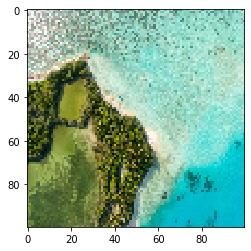

In [1]:
from PIL import Image
from PIL import ImageColor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = np.array(Image.open('image1.png'))
h, w, c = img.shape
plt.imshow(img)

img_array = img.reshape(-1,3) # (10000,3)


img_coord = np.zeros([h*w, 2], dtype='uint8')

for i in range(h*w):
    img_coord[i,1] = i%h
for i in range(h*w):
    img_coord[i,0] = i //h

## Initialization (centers & clusters)

In [2]:
def Initial_Kmeans(data, k, mode):
    center_x = np.random.randint(0, h, k)
    center_y = np.random.randint(0, h, k)
    
    if mode == 'modK':
        prev = []
        for i in range(h*w):
            prev.append(i%k)
        return center_x, center_y, np.array(prev)
    elif mode == 'equal':
        prev = []
        for i in range(h*w):
            prev.append(int(i / (h*w/k)))
        return center_x, center_y, np.array(prev)
    else:
        prev = np.random.randint(0, k, h*w)
        return center_x, center_y, prev
        

center_x, center_y, classification = Initial_Kmeans(img_array, 4, 'a')

## Kernel
For  both kernel  k-means  and  spectral  clustering,  please  use  the  new  kernel defined below to compute the Gram matrix.
$\mathrm{k}\left(x, x^{\prime}\right)=e^{-\gamma_{s}\left\|S(x)-S\left(x^{\prime}\right)\right\|^{2}} \times e^{-\gamma_{c}\left\|C(x)-C\left(x^{\prime}\right)\right\|^{2}}$

In [3]:
from scipy.spatial.distance import pdist, squareform

gamma_c = 1/(255*255)
gamma_s = 1/(100*100)

def kernel(color, coord):
    
    spatial_K = np.exp(-gamma_s * squareform(pdist(coord, 'sqeuclidean')))
    color_K = np.exp(-gamma_c * squareform(pdist(color, 'sqeuclidean')))

    return spatial_K * color_K

## Loss
$\mathbf{k}\left(x_{j}, x_{j}\right)-\frac{2}{\left|C_{k}\right|} \sum_{n} \alpha_{k n} \mathbf{k}\left(x_{j}, x_{n}\right)+\frac{1}{\left|C_{k}\right|^{2}} \sum_{p} \sum_{q} \alpha_{k p} \alpha_{k q} \mathbf{k}\left(x_{p}, x_{q}\right)$

In [4]:
def second_loss(kernel_data, classification, idx, cluster):
    cluster_sum = 0
    kernel_sum = 0
    cluster_sum = len(classification[classification == cluster]) # correct cluster num |Ck|
    kernel_sum = np.sum(kernel_data[idx][classification == cluster]) # correct cluster kernel value sum (10000,10000)
    
      
    if cluster_sum == 0:
        cluster_sum = 1 # prvent from divided zero

    return (-2) / cluster_sum * kernel_sum

def third_loss(kernel_data, classification, k):
    cluster_sum = np.zeros(k, dtype='int')
    kernel_sum = np.zeros(k)
    
    for i in range(k):
        cluster_sum[i] = np.count_nonzero(classification==i) # correct cluster num |Ck|

    
    for cluster in range(k):
        same_row = kernel_data[classification == cluster] # row prediction equal to cluster
        same_col = same_row[:, classification == cluster] # col prediction equal to cluster
        kernel_sum[cluster] = np.sum(same_col) # same cluster kernel value sum
    
    for i in range(k):
        if cluster_sum[i] == 0:
            cluster_sum[i] = 1 # prvent from divided zero
        kernel_sum[i] = 1 / (cluster_sum[i]**2) * kernel_sum[i]
    
    return kernel_sum
        
def total_loss(data, kernel_data, classification, k):
    new_classification = np.zeros(data.shape[0], dtype='int') # New loss for each point
    loss_3 = third_loss(kernel_data, classification, k) # 3 terms for same cluster points relation

    for idx in range(data.shape[0]): # Calculate each point's loss (10000)
        loss_for_class = np.zeros(k)
        for cluster in range(k):
            loss_for_class[cluster] = second_loss(kernel_data, classification, idx, cluster) + loss_3[cluster]
        new_classification[idx] = np.argmin(loss_for_class)
    
    return new_classification

    
def visualize(img_array, classification, color, iteration, initial, file_name):
    h_w, c = img_array.shape
    h = w = int(h_w**0.5)
    img = img_array.reshape(h, w, c)
    for i in range(h):
        for j in range(w):
            img[i,j] = color[classification[i*h + j]]
    
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    result = Image.fromarray((img).astype('uint8'))
    # result.save(f'{file_name}_{initial}_{iteration:02}.png')

## Visualization

classification shape = (10000,)
iteration = 0


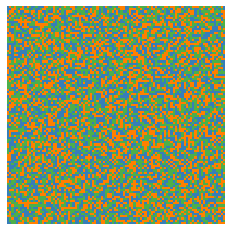

Error = 8158
iteration = 1


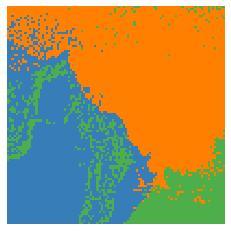

Error = 1630
iteration = 2


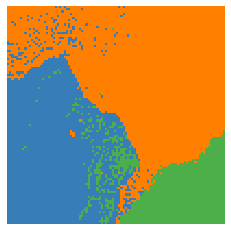

Error = 974
iteration = 3


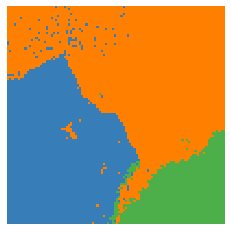

Error = 153
iteration = 4


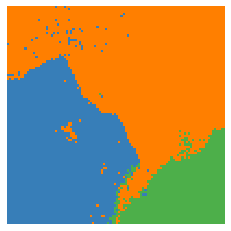

Error = 42
iteration = 5


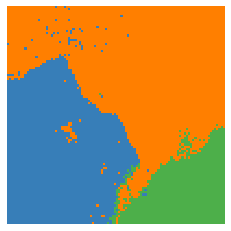

Error = 35
iteration = 6


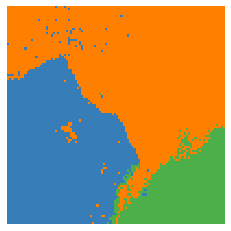

Error = 18
iteration = 7


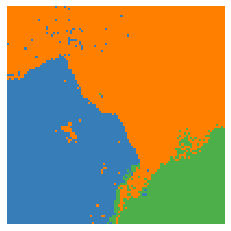

Error = 18
iteration = 8


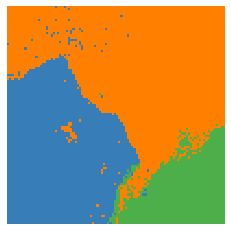

Error = 10
iteration = 9


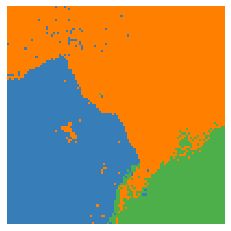

Error = 8
iteration = 10


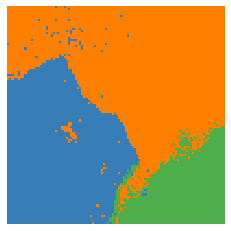

Error = 9
iteration = 11


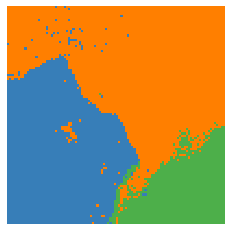

Error = 4
iteration = 12


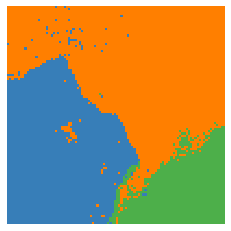

Error = 1
iteration = 13


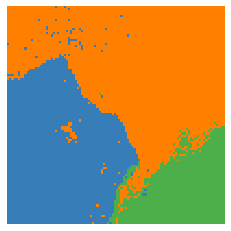

Error = 0
iteration = 14


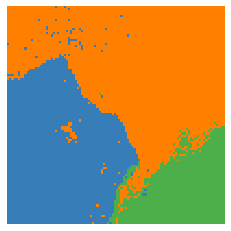

Error = 0
iteration = 15


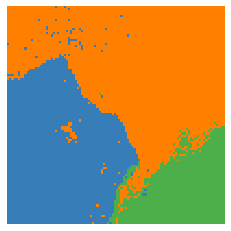

Error = 0
iteration = 16


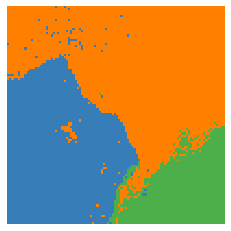

Error = 0
iteration = 17


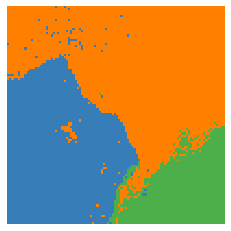

Error = 0
iteration = 18


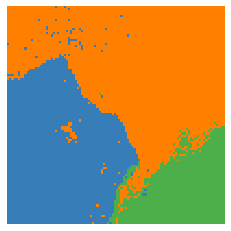

Error = 0
iteration = 19


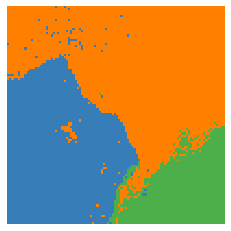

Error = 0


In [5]:
color_select = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
color_rgb = []
for c in color_select:
    color_rgb.append(ImageColor.getrgb(c))
    

def Kernel_K_Means(data, coord, k, initial, file_name, max_iteration=20, color_rgb=color_rgb):
    

    Cx, Cy, classification = Initial_Kmeans(data, k, initial)
    kernel_data = kernel(data, coord)

    iteration = 0
    prev_error = -np.inf
    print(f'classification shape = {classification.shape}')

    while(iteration < max_iteration):
        print(f'iteration = {iteration}')
        prev_classification = classification
        visualize(data, classification, color_rgb, iteration, initial, file_name)
        classification = total_loss(data, kernel_data, classification, k)
        error = np.sum(np.absolute(classification - prev_classification))
        print(f'Error = {error}')

#         if error == prev_error:
#             break
        prev_error = error
        iteration += 1

# initialization = ['random', 'modK', 'equal-divide']
Kernel_K_Means(img_array, img_coord, k=3, initial='random', file_name='coast')

## GIF

In [6]:
# import imageio as io
# import os



# file_names = sorted((fn for fn in os.listdir('.') if fn.startswith('rabbit_random')))

# #making animation
# with io.get_writer('rabbit_2_1e2.gif', mode='I', duration=0.5) as writer:
#     for filename in file_names:
#         print(filename)
#         image = io.imread(filename)
#         writer.append_data(image)
# writer.close()